In [1]:
using DrWatson
@quickactivate :SwARExperiments

In [2]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
using Parameters
using LinearAlgebra
import ProgressMeter

In [3]:
using Plots
using PGFPlotsX
using LaTeXStrings
using ColorSchemes
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

## Switching AR

## Generate AR

In [4]:
seed = 2
n_samples = 5000
n_states = 2
ar_order = 2
l_slice = 100
n_buckets = div(n_samples, l_slice)

coefs_set = [generate_coefficients(seed*i,  ar_order) for i in 1:n_states]
prec_set  = sample(MersenneTwister(seed), [0.01, 0.1, 1.0, 10.0, 100.0], n_states, replace=false)
# prec_set  = sample(MersenneTwister(seed), [inv(0.00012076092747935885), inv(0.0005755920568259142)], n_states, replace=false)

gen_A, gen_states, observations = generateSwAR(seed, n_samples, l_slice, n_states, ones(n_states), coefs_set, prec_set)
inputs, outputs = observations[1], observations[2];

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

(GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=0.1, b=10.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
, MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [0.1 0.1; 0.1 0.1])

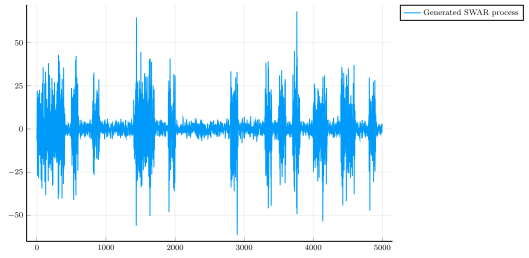

In [5]:
plot(outputs, label="Generated SWAR process")

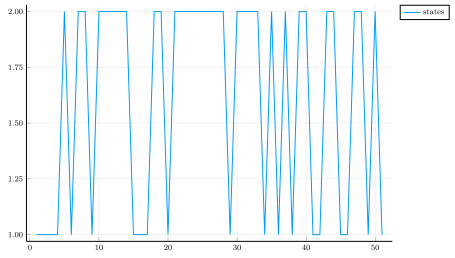

In [6]:
real_states = last.(findmax.(gen_states))
plot(real_states, label="states")

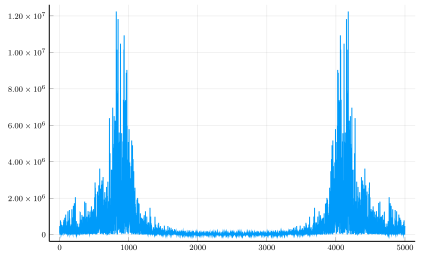

In [7]:
using FFTW
plot(abs.(fft(outputs)).^2, label=false)

In [8]:
# csep = 1000.0

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

parameters = SwARParameters(n_states, priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A)


SwARParameters(2, GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=0.1, b=10.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
, MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [0.1 0.1; 0.1 0.1])

In [9]:
result = InferenceResults(inference_swar(inputs, outputs, 50, 20, parameters)...);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


In [10]:
mean(result.mA[end])

2×2 Matrix{Float64}:
 0.168176  0.00200782
 0.831824  0.997992

In [11]:
gen_A

2×2 Matrix{Float64}:
 0.244035  0.366421
 0.755965  0.633579

In [16]:
mean.(result.mθs[end])

50-element Vector{Vector{Float64}}:
 [0.6860097059223657, -0.6447680724832136]
 [0.7071491530889451, -0.7417853857222747]
 [0.7968306257764551, -0.6668456158068865]
 [0.740367131149647, -0.7702085997620304]
 [1.2706584871815958, -0.6283436630746527]
 [0.9366161978715386, -0.652805666486058]
 [1.3360083474913713, -0.6949112224545126]
 [1.3183372055624019, -0.6413514443939814]
 [0.7436087979985101, -0.6484910550887631]
 [1.3988900869595868, -0.7834040624557858]
 [1.292574182865126, -0.6706228788001434]
 [1.186816398960524, -0.5978578466435873]
 [1.3791235119066154, -0.7369351197406387]
 ⋮
 [1.3316925547703615, -0.6781327032720238]
 [1.366303663058128, -0.7297263369580906]
 [0.6923592558011045, -0.6568844126784249]
 [0.7770085186068006, -0.714250226360214]
 [1.3216219574613521, -0.6941040739942689]
 [1.3792639907893425, -0.7321445721309985]
 [0.7101587218549823, -0.7148373935221725]
 [0.6695877321586463, -0.6675495457083958]
 [1.3752241933288076, -0.77702521159418]
 [1.3425467009444605, -

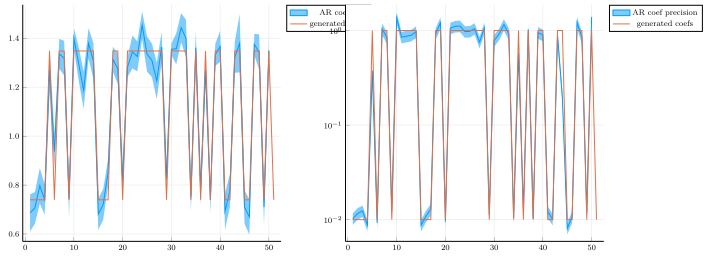

In [17]:
dimension(n) = (x) -> map(i -> i[n], x)
index = 1
mγs = result.mγs
mθs = result.mθs

p1 = plot(mean.(mθs[end]) |> dimension(index), ribbon = sqrt.(var.(mθs[end]) |> dimension(index)), label="AR coef $(index)")
plot!([coefs_set[state][index] for state in real_states], label="generated coefs")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")
plot!([prec_set[state] for state in real_states], label="generated coefs")

plot(p1, p2, size = (900, 400))

In [ ]:
using Colors
cols = distinguishable_colors(2, [RGB(0,0,0), RGB(0.3,0.2,0.9)], dropseed=true)
colors = collect(Iterators.flatten(map(e -> Iterators.repeated(e, l_slice), real_states[1:end-1])))
real_colors = map(x -> cols[x], colors)

In [71]:
from, to = 1, n_buckets
# xtick = from*ar_data_len:1000:to*ar_data_len,
axis1 = @pgf Axis({xlabel=L"t",
           ylabel="value", scaled_x_ticks="base 10:0",
           xtick_distance=10,
           xmin = (from)+1, 
           xmax = to, 
           legend_pos = "outer north east",
           legend_cell_align="{left}",
           grid = "major", style={"ultra thin"},
           width="20cm", height="10cm",
    },
    Plot({no_marks, style={"ultra thick"}, color=cols[1]}, Coordinates(zeros(1), zeros(1))), LegendEntry("AR-1"),
    Plot({no_marks, style={"ultra thick"}, color=cols[2]}, Coordinates(zeros(1), zeros(1))), LegendEntry("AR-2"),
    Iterators.flatten([
                      [Plot(
                            {no_marks, color=real_colors[from*l_slice+(i-1)*l_slice+1:from+i*l_slice][1]},
                            Coordinates(
                                 collect(from+(i-1)*l_slice:from+i*l_slice), 
                                 outputs[from+(i-1)*l_slice:from+i*l_slice]
                            ),
                        ) for i in 1:to-from]])...
)

Axis(PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("xlabel" => L"$t$", "ylabel" => "value", "scaled_x_ticks" => "base 10:0", "xtick_distance" => 10, "xmin" => 2, "xmax" => 50, "legend_pos" => "outer north east", "legend_cell_align" => "{left}", "grid" => "major", "style" => PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("ultra thin" => nothing), true)…), true), Any[Plot(false, false, PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("no_marks" => nothing, "style" => PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("ultra thick" => nothing), true), "color" => RGB{Float64}(0.9676665061836248,1.0,0.06769836692850456)), true), Coordinates{2}(Union{Nothing, Coordinate{2}}[Coordinate{2}((0.0, 0.0), nothing, nothing, nothing, nothing)]), Any[]), LegendEntry(PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}(), false), "AR-1", false), Plot(false, false, PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("no_marks" => nothing, "style" 

! Dimension too large.
\pgfplotsaxisdeserializedatapointfrom@private@LUA ...
                                                  \global \pgf@y =#2pt \pgfp...
l.5176 \end{axis}
               
! Dimension too large.
\pgfplotsaxisdeserializedatapointfrom@private@LUA ...
                                                  \global \pgf@y =#2pt \pgfp...
l.5176 \end{axis}
               


In [25]:
from, to = 1, length(outputs)
outputs[from:l_slice]

100-element Vector{Float64}:
  -6.756644718249158
   0.49465859835759485
  -3.2196150333543425
   2.431280442151881
  16.67754958445811
  22.216084221991963
   3.084741961790439
 -27.182526172386112
 -22.520102805950074
   9.372564948067113
  16.89540668184073
   2.9174796224632704
  -7.515956110951118
   ⋮
  25.56457146305712
  35.67718595364188
  17.744441935477916
  -9.375075292802885
 -14.975815839911848
  -2.0928693888231127
   3.846628578560116
   7.226183944911593
  -3.098517165700557
 -20.906171728419835
 -13.549262797600889
   5.00572326901084

In [23]:
plt_swar = @pgf Axis({
        title="Generated SWAR process",
        yticklabel_style={
        "/pgf/number format/fixed,
        /pgf/number format/precision=3"
        },
        grid="major",
        xmin=0.0, xmax=5000,
        yminorgrids=true,
        tick_align="outside",
        scaled_y_ticks = false,
        xlabel=L"t", ylabel="value"
    }, Plot({no_marks,color=real_colors[1:length(outputs)]}, Coordinates(collect(1:length(outputs)), outputs))
    )

Axis(PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("title" => "Generated SWAR process", "yticklabel_style" => PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("/pgf/number format/fixed,\n        /pgf/number format/precision=3" => nothing), true), "grid" => "major", "xmin" => 0.0, "xmax" => 5000, "yminorgrids" => true, "tick_align" => "outside", "scaled_y_ticks" => false, "xlabel" => L"$t$", "ylabel" => "value"…), true), Any[Plot(false, false, PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("no_marks" => nothing, "color" => RGB{Float64}[RGB{Float64}(0.9676665061836248,1.0,0.06769836692850456), RGB{Float64}(0.9676665061836248,1.0,0.06769836692850456), RGB{Float64}(0.9676665061836248,1.0,0.06769836692850456), RGB{Float64}(0.9676665061836248,1.0,0.06769836692850456), RGB{Float64}(0.9676665061836248,1.0,0.06769836692850456), RGB{Float64}(0.9676665061836248,1.0,0.06769836692850456), RGB{Float64}(0.9676665061836248,1.0,0.06769836692850456), RGB{Float64}(0.967

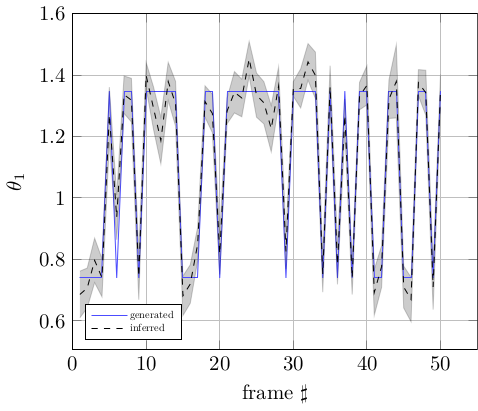

In [15]:
index = 1
dimension(n) = (x) -> map(i -> i[n], x)

plt_states = @pgf Axis(
    {   xlabel="frame "*L" \sharp",
        xmin=0.0,
        legend_pos = "south west",
        legend_cell_align="{left}",
        grid = "major",
        ylabel=L"\theta_{1}",
        legend_style = "{nodes={scale=0.5, transform shape}}",
    },
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_buckets), [coefs_set[state][index] for state in real_states[1:end-1]])), LegendEntry("generated"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_buckets), mean.(result.mθs[end]) |> dimension(index))),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), (mean.(result.mθs[end]) |> dimension(index)) .+  (sqrt.(var.(result.mθs[end]) |> dimension(index))) )),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_buckets), (mean.(result.mθs[end]) |> dimension(index)) .-  (sqrt.(var.(result.mθs[end]) |> dimension(index))) )),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred")
)


In [144]:
mγs = result.mγs
real_states = last.(findmax.(gen_states))

plt_gamma = @pgf Axis(
{   xlabel="frame "*L" \sharp",
    xmin=0.0,
    legend_pos = "north east",
    legend_cell_align="{left}",
    grid = "major",
    ylabel=L"\gamma",
    legend_style = "{nodes={scale=0.5, transform shape}}",
},
Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_buckets), [prec_set[state] for state in real_states[1:end-1]])), LegendEntry("generated"),
Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_buckets), mean.(mγs[end]))),
Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), mean.(mγs[end]) .+  std.(mγs[end]))),
Plot({"name path=g", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), mean.(mγs[end]) .-  std.(mγs[end]))),
Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
        raw"fill between [of=f and g]"), LegendEntry("inferred")
)

In [ ]:
plt_acoustic = @pgf Axis({
    yticklabel_style={
    "/pgf/number format/fixed,
    /pgf/number format/precision=3"
    },
    legend_pos="north west",
    grid="major",
    yminorgrids=true,
    xmin=0.0,
    xmax=8.0,
    tick_align="outside",
    each_nth_point=10,
    scaled_y_ticks = false,
    ytick_distance=0.1, grid = "major", style={"ultra thin"},
    width="8cm", height="5cm",
    xlabel="sec", ylabel="amplitude",
},
Plot(
    {no_marks,color="cyan",fill_opacity=0.0, mark_size=4.0, mark="*"},
    Coordinates(collect(0:1/fs:length(signal)/fs)[1:end-1], signal)
    ), LegendEntry("signal"),
Plot({only_marks, scatter, scatter_src = "explicit"},
    Table(
        {x = "x", y = "y", meta = "col"},
        x = collect(0:1/fs:length(signal)/fs)[1:length(states)], y = -0.15*ones(length(states)), col = states
        ),
     ),
)

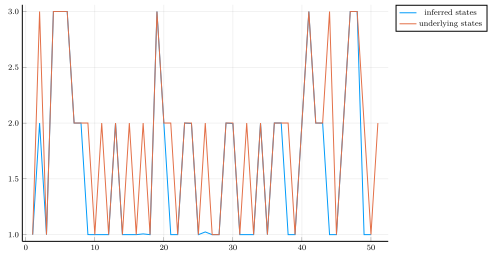

In [374]:
real_states = last.(findmax.(gen_states))
plot(mean.(mzs[end][1:end]), label="inferred states")
plot!(real_states, label="underlying states")

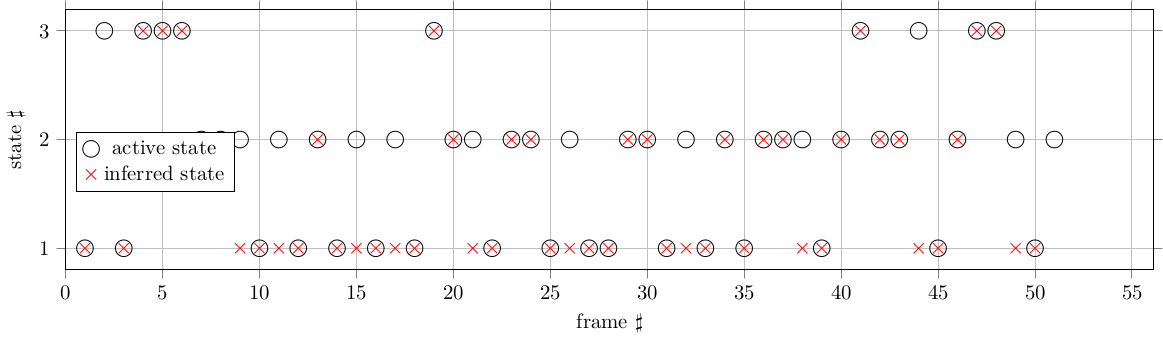

In [375]:
plt_states = @pgf Axis({
    yticklabel_style={
    "/pgf/number format/fixed,
    /pgf/number format/precision=3"
    },
    legend_style="{at={(0.01,0.3)},anchor=south west}",
    grid="major",
    yminorgrids=true,
    xmin=0.0,
    tick_align="outside",
    scaled_y_ticks = false,
    ytick_distance=1, grid = "major", style={"ultra thin"},
    width="20cm", height="6cm",
    xlabel="frame "*L" \sharp", ylabel="state "*L" \sharp",
},
Plot(
    {only_marks,color="black",fill_opacity=0.0, mark_size=4.0, mark="*"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(real_states)), y = real_states
        )
    ), LegendEntry("active state"),
Plot(
    {fill="black", only_marks,color="red", mark_size=3.5, opacity=1.0, mark="x"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(mzs[end])), y = round.(mean.(mzs[end][1:end]))
        ),
    ), LegendEntry("inferred state"),
)



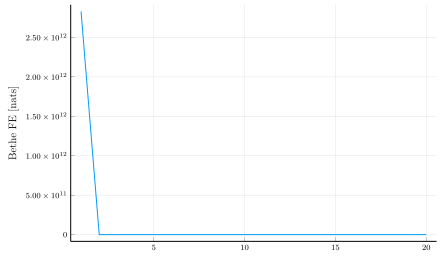

In [376]:
plot(mfe[1:end], label=:none, ylabel="Bethe FE [nats]")

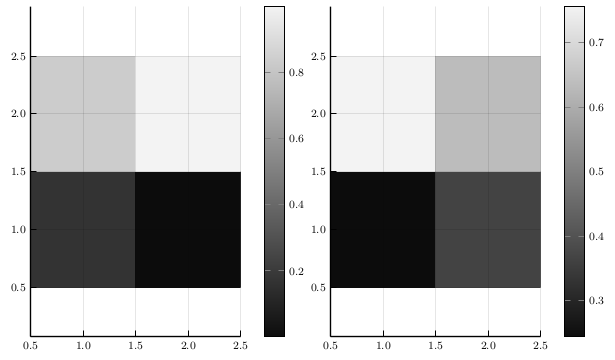

In [22]:
mA = result.mA
xs = collect(1:n_states)
ys = collect(1:n_states)
p1 = heatmap(xs, ys, mean(mA[end]), aspect_ratio = 1,color=:grays)
p2 = heatmap(xs, ys, gen_A, aspect_ratio = 1, color=:grays)
plot(p1, p2)

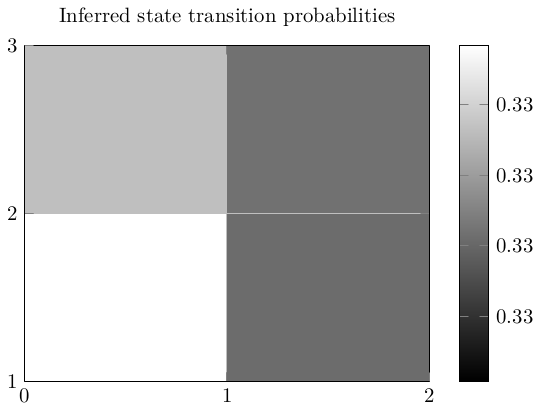

In [466]:
axis1 = @pgf Axis(
    {
        xtick=collect(0:n_states),
        ytick=collect(0:n_states),
        title="Inferred state transition probabilities",
        legend_pos = "north east",
        legend_cell_align="{left}",
        grid = "major",
        view = (0, 90),
        colorbar,
        "colormap/blackwhite",
        colorbar_style={"xticklabel pos=upper"}
    },
    Plot3(
        {
            surf,
            shader = "flat corner",
        },
        Coordinates(collect(1:3), collect(1:3), mean(mA[end]))),
    )